In [33]:
import os
import sys
import csv
import pandas as pd
import numpy as np

import os.path
from os import path

import openslide
from skimage.color import rgb2hsv
import PIL
from PIL import Image

import cv2
import glob
import h5py
import os
import pathlib
import tables

import torch
from skimage import io, transform
from sklearn import metrics
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib import pyplot

import torch
import timm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.functional import kl_div, softmax, log_softmax

In [2]:
hdf5_path = '/home/irene/Downloads/luadlusc.hdf5'
file = h5py.File(hdf5_path, "r")
file.keys()

<KeysViewHDF5 ['test_img', 'test_label', 'train_img', 'train_label', 'val_img', 'val_label']>

In [3]:
rgb_mean,rgb_std = (0.485, 0.456, 0.406),(0.229, 0.224, 0.225)

In [4]:
class HDF5Dataset(Dataset):


    def __init__(self, h5_path, set_name, transform = None):
        self.h5_path = h5_path
        self.dataset = None
        self.transform = transform
        self.file_path  = h5_path
        self.set = set_name
        
        str_name = self.set + "_img"
        
        file = h5py.File(h5_path, "r")
        self.dataset_len = len(file[str_name])
        
        self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(rgb_mean,rgb_std)
            ])
        
    def __getitem__(self, index): #to enable indexing
        
        if self.dataset is None:
            self.imgs = h5py.File(self.file_path, 'r')[self.set + "_img"]
            self.labels = h5py.File(self.file_path, 'r')[self.set + "_label"]
            
            cur_img = self.imgs[index]
            PIL_image = Image.fromarray(np.uint8(cur_img)).convert('RGB')#3 channels don't need alpha channel network input
            image = self.transform(PIL_image)
            label = self.labels[index].astype('float32')
            
            
        return (image,label)

    def __len__(self):
        return self.dataset_len

In [5]:
from torch.utils.data import Dataset,DataLoader

train_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="train"), batch_size=8,shuffle=True,drop_last=False)
val_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="val"), batch_size=8,shuffle=True,drop_last=False)
test_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="test"), batch_size=8,shuffle=True,drop_last=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_dim = 2

model = timm.create_model("resnet50", pretrained=True)
model.fc = nn.Linear(model.fc.in_features, out_dim)

model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay = 1e-4,momentum = 0.9)
criterion = nn.CrossEntropyLoss()



def train_valid_model (net,loaders,max_epochs = 20):
    best_acc = 0.0 
    for epoch in range (max_epochs):
        for phase in ['train','val']:
            iterator = iter(loaders[phase])
            total_step = len(loaders[phase])
            print('Phase {}'.format(phase))
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            running_loss = 0.0
            running_correct = 0
            
            predictions_all = []
            label_all = []
            probs_all = []
            for step in range(total_step-1): #iterate each batch
                images,labels = next(iterator) # CUDA computation
                images = images.to(device)
                labels = labels.to(device)
                labels = labels.long()
                optimizer.zero_grad()
                
                output = net(images)
                loss = criterion(output,labels)
                
                probs = torch.nn.functional.softmax(output, dim=1) # probabilities
                
                running_loss +=loss.item()
                _, preds = torch.max(output.data,1)
                
                running_correct += (preds == labels).sum().item()
                
                if len(predictions_all) == 0:
                    predictions_all = preds.detach().cpu().numpy()
                    label_all = labels.detach().cpu().numpy()
                    probs_all = probs.detach().cpu().numpy()
                else:
                    predictions_all = np.vstack((predictions_all, preds.detach().cpu().numpy()))
                    probs_all = np.vstack((probs_all, probs.detach().cpu().numpy()))
                    label_all = np.vstack((label_all, labels.detach().cpu().numpy()))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
                    
            phase_loss = running_loss / len(loaders[phase])
            phase_acc = running_correct/len(label_all.flatten())
            if phase == 'val':
                y_true = label_all.flatten()
                y_pred = predictions_all.flatten()
                print("validating...")
                print(len(y_true))
                print(len(y_pred))
                print(metrics.classification_report(y_true, y_pred, digits=3))
            if phase == 'val' and phase_acc > best_acc:
                
                best_acc = phase_acc
                import copy 
                
                best_model_state_dict = copy.deepcopy(net.state_dict())
                torch.save(best_model_state_dict,'resnet50best_model.pth')
                
            print('PHASE {} Loss: {:.4f} Acc: {:.4f}'.format(phase, phase_loss, phase_acc))
    net.load_state_dict(best_model_state_dict)
    
    return net 
            
       
print(device)  

cuda


In [34]:
def test_best_model (net, test_loader, a_device = None):
    iterator = iter(test_loader)
    total_step = len(test_loader)
    
    print(total_step)
    net.eval()
    
    with torch.no_grad():
        running_loss = 0
        running_corrects = 0
        
        total_0,total_1 = 0,0
        hit_0 = 0
        hit_1 = 0
        label_all = []
        probs_all = []
        predictions_all = []
        for step in range(total_step-1):
            images,labels = next(iterator)
            images.to(a_device)
            labels.to(a_device)
            total_0 += labels.tolist().count(0)
            total_1 += labels.tolist().count(1)
            print(labels.shape)
            images = images.to(a_device)
            labels = labels.to(device=a_device, dtype=torch.int64)
            labels = labels.long()
            
            output = net(images)
            loss = criterion(output,labels)
            
            probs = torch.nn.functional.softmax(output, dim=1)

            running_loss +=loss.item()
            _, preds = torch.max(output.data,1)
            
            equals = preds == labels.view(*preds.shape)
            if(len(label_all) ==0):
                predictions_all = preds.detach().cpu().numpy()
                label_all = labels.detach().cpu().numpy()
                probs_all = probs.detach().cpu().numpy()
            else:
                predictions_all = np.vstack((predictions_all, preds.detach().cpu().numpy()))
                label_all = np.vstack((label_all, labels.detach().cpu().numpy()))
                probs_all = np.vstack((probs_all, probs.detach().cpu().numpy()))

            all_hits = equals.view(equals.shape[0]).tolist() 
            all_corrects = labels[all_hits]
            
            hit_0 += all_corrects.tolist().count(0)
            hit_1 += all_corrects.tolist().count(1)
 
        
            running_corrects += (preds == labels).sum().item()
        print(len(label_all.flatten()))
        label_all = label_all.flatten()
        predictions_all = predictions_all.flatten()
        phase_loss = running_loss / len(test_loader)
        phase_acc = running_corrects/len(label_all.flatten())
        print('Test Loss: {:.4f} Acc: {:.4f}'.format(phase_loss, phase_acc))
        
        print(hit_0, ' / ',total_0)
        print(hit_1, ' / ',total_1)
                
            
    return label_all, probs_all, predictions_all #add this later
                
        #y_test --> label, y_score --> probs all 

In [8]:
epochs = 10
loaders = dict({'train': train_loader, 'val': val_loader})
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------")
    bestmodel = train_valid_model (model,loaders)
    

Epoch 1
-----------------------
Phase train
PHASE train Loss: 0.4042 Acc: 0.8057
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.935     0.898     0.916      4528
           1      0.917     0.947     0.932      5400

    accuracy                          0.925      9928
   macro avg      0.926     0.923     0.924      9928
weighted avg      0.925     0.925     0.925      9928

PHASE val Loss: 0.1870 Acc: 0.9250
Phase train
PHASE train Loss: 0.2298 Acc: 0.9042
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.951     0.958     0.955      4529
           1      0.964     0.959     0.962      5399

    accuracy                          0.958      9928
   macro avg      0.958     0.958     0.958      9928
weighted avg      0.958     0.958     0.958      9928

PHASE val Loss: 0.1031 Acc: 0.9584
Phase train
PHASE train Loss: 0.1501 Acc: 0.9412
Phase val
validating...
9928


PHASE train Loss: 0.0111 Acc: 0.9965
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.990     0.994     0.992      4528
           1      0.995     0.992     0.993      5400

    accuracy                          0.993      9928
   macro avg      0.992     0.993     0.992      9928
weighted avg      0.993     0.993     0.993      9928

PHASE val Loss: 0.0248 Acc: 0.9925
Epoch 2
-----------------------
Phase train
PHASE train Loss: 0.0123 Acc: 0.9957
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.988     0.989     0.989      4528
           1      0.991     0.990     0.990      5400

    accuracy                          0.990      9928
   macro avg      0.989     0.989     0.989      9928
weighted avg      0.990     0.990     0.990      9928

PHASE val Loss: 0.0354 Acc: 0.9895
Phase train
PHASE train Loss: 0.0149 Acc: 0.9951
Phase val
validating...
9928
9928
       

PHASE train Loss: 0.0058 Acc: 0.9982
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.993     0.977     0.985      4528
           1      0.981     0.994     0.988      5400

    accuracy                          0.986      9928
   macro avg      0.987     0.986     0.986      9928
weighted avg      0.986     0.986     0.986      9928

PHASE val Loss: 0.0485 Acc: 0.9864
Phase train
PHASE train Loss: 0.0100 Acc: 0.9964
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.995     0.988     0.992      4528
           1      0.990     0.996     0.993      5400

    accuracy                          0.992      9928
   macro avg      0.993     0.992     0.992      9928
weighted avg      0.992     0.992     0.992      9928

PHASE val Loss: 0.0244 Acc: 0.9923
Epoch 3
-----------------------
Phase train
PHASE train Loss: 0.0056 Acc: 0.9983
Phase val
validating...
9928
9928
       

PHASE train Loss: 0.0086 Acc: 0.9972
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.990     0.996     0.993      4529
           1      0.997     0.991     0.994      5399

    accuracy                          0.994      9928
   macro avg      0.993     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0239 Acc: 0.9937
Phase train
PHASE train Loss: 0.0037 Acc: 0.9991
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.994     0.996     0.995      4528
           1      0.997     0.995     0.996      5400

    accuracy                          0.995      9928
   macro avg      0.995     0.996     0.995      9928
weighted avg      0.995     0.995     0.995      9928

PHASE val Loss: 0.0154 Acc: 0.9955
Phase train
PHASE train Loss: 0.0039 Acc: 0.9989
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0066 Acc: 0.9973
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.995     0.984     0.989      4529
           1      0.987     0.996     0.991      5399

    accuracy                          0.990      9928
   macro avg      0.991     0.990     0.990      9928
weighted avg      0.990     0.990     0.990      9928

PHASE val Loss: 0.0291 Acc: 0.9902
Phase train
PHASE train Loss: 0.0098 Acc: 0.9968
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.995     0.992     0.994      4529
           1      0.993     0.996     0.995      5399

    accuracy                          0.994      9928
   macro avg      0.994     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0229 Acc: 0.9942
Phase train
PHASE train Loss: 0.0066 Acc: 0.9976
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0086 Acc: 0.9970
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.992     0.992     0.992      4529
           1      0.994     0.993     0.993      5399

    accuracy                          0.993      9928
   macro avg      0.993     0.993     0.993      9928
weighted avg      0.993     0.993     0.993      9928

PHASE val Loss: 0.0254 Acc: 0.9928
Phase train
PHASE train Loss: 0.0060 Acc: 0.9981
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.989     0.997     0.993      4529
           1      0.998     0.991     0.994      5399

    accuracy                          0.994      9928
   macro avg      0.994     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0221 Acc: 0.9939
Phase train
PHASE train Loss: 0.0030 Acc: 0.9990
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0086 Acc: 0.9968
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.996     0.991     0.993      4528
           1      0.993     0.996     0.995      5400

    accuracy                          0.994      9928
   macro avg      0.994     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0204 Acc: 0.9941
Phase train
PHASE train Loss: 0.0066 Acc: 0.9980
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.994     0.987     0.990      4529
           1      0.989     0.995     0.992      5399

    accuracy                          0.991      9928
   macro avg      0.992     0.991     0.991      9928
weighted avg      0.991     0.991     0.991      9928

PHASE val Loss: 0.0328 Acc: 0.9913
Phase train
PHASE train Loss: 0.0050 Acc: 0.9985
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0035 Acc: 0.9989
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.995     0.989     0.992      4529
           1      0.991     0.996     0.993      5399

    accuracy                          0.993      9928
   macro avg      0.993     0.992     0.993      9928
weighted avg      0.993     0.993     0.993      9928

PHASE val Loss: 0.0260 Acc: 0.9927
Phase train
PHASE train Loss: 0.0032 Acc: 0.9991
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.995     0.993     0.994      4529
           1      0.994     0.996     0.995      5399

    accuracy                          0.994      9928
   macro avg      0.995     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0198 Acc: 0.9945
Phase train
PHASE train Loss: 0.0024 Acc: 0.9993
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0078 Acc: 0.9975
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.989     0.987     0.988      4529
           1      0.989     0.991     0.990      5399

    accuracy                          0.989      9928
   macro avg      0.989     0.989     0.989      9928
weighted avg      0.989     0.989     0.989      9928

PHASE val Loss: 0.0362 Acc: 0.9893
Phase train
PHASE train Loss: 0.0063 Acc: 0.9978
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.981     0.993     0.987      4529
           1      0.994     0.984     0.989      5399

    accuracy                          0.988      9928
   macro avg      0.988     0.989     0.988      9928
weighted avg      0.988     0.988     0.988      9928

PHASE val Loss: 0.0423 Acc: 0.9883
Phase train
PHASE train Loss: 0.0051 Acc: 0.9983
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0028 Acc: 0.9992
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.985     0.995     0.990      4528
           1      0.996     0.987     0.992      5400

    accuracy                          0.991      9928
   macro avg      0.991     0.991     0.991      9928
weighted avg      0.991     0.991     0.991      9928

PHASE val Loss: 0.0335 Acc: 0.9909
Phase train
PHASE train Loss: 0.0029 Acc: 0.9991
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.994     0.992     0.993      4528
           1      0.993     0.995     0.994      5400

    accuracy                          0.993      9928
   macro avg      0.993     0.993     0.993      9928
weighted avg      0.993     0.993     0.993      9928

PHASE val Loss: 0.0263 Acc: 0.9933
Phase train
PHASE train Loss: 0.0082 Acc: 0.9973
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0018 Acc: 0.9995
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.996     0.993     0.994      4529
           1      0.994     0.996     0.995      5399

    accuracy                          0.995      9928
   macro avg      0.995     0.995     0.995      9928
weighted avg      0.995     0.995     0.995      9928

PHASE val Loss: 0.0197 Acc: 0.9948
Phase train
PHASE train Loss: 0.0021 Acc: 0.9994
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.996     0.991     0.993      4528
           1      0.992     0.996     0.994      5400

    accuracy                          0.994      9928
   macro avg      0.994     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0186 Acc: 0.9939
Phase train
PHASE train Loss: 0.0035 Acc: 0.9989
Phase val
validating...
9928
9928
              precision    recall  f1-s

In [19]:
model_path = 'resnet50best_model.pth'

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_dim = 2

model = timm.create_model("resnet50", pretrained=True)
model.fc = nn.Linear(model.fc.in_features, out_dim)

In [21]:
my_dict = torch.load(model_path)

In [22]:
model.load_state_dict(my_dict)

<All keys matched successfully>

In [24]:
model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay = 1e-4,momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [35]:
y_test, y_prob, y_pred= test_best_model (model, test_loader, a_device = device)


1242
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
tor

torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Si

torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Si

In [36]:
fpr = dict()
tpr = dict()

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])

In [37]:
roc_auc = roc_auc_score(y_test, y_prob[:,1])
print('AUC: %.3f' % roc_auc)

AUC: 1.000


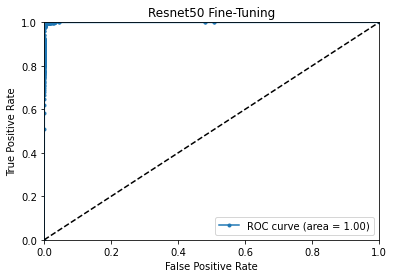

In [38]:
# ROC Curves and AUC
plt.plot(fpr,tpr ,marker='.', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Resnet50 Fine-Tuning')
plt.legend(loc="lower right")
plt.savefig('Resnet50 Fine-Tuning.png')

In [39]:
accuracy = accuracy_score(y_test,y_pred,normalize = True)

In [40]:
print(accuracy)

0.9941579371474617


In [41]:
f1 = f1_score(y_test, y_pred)

In [42]:
print(f1)

0.9946336047372316
